In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor, ToPILImage
# from torchvision.datasets.imagenet import ImageNet
from PIL import Image
from PIL import ImageFilter
import glob
import numpy as np
import matplotlib.pyplot as plt

## Data preprocessing

*1. input channel convert?*

*1-1 img pre processing*

**2. channel size, filter size, use padding**

**3. weight initialize**

**4. learning rate**

**5. inference**


In [2]:
# randomly cropping from training sample with size(33,33,3) and stride 14(91img train set)
# blur sub-image by gaussian kernel
# bicubic interpolation with upscale factor 3

## RandomResizedCrop()함수를 사용하는 것은 어떤가?

# through PIL
class SRdataset(Dataset):
    def __init__(self, data_path, sub_img_size, size_gap, stride, upscale_factor):
        super(Dataset, self).__init__()
        self.data_path = glob.glob(data_path)
        # data color channel 확인
        tmp = Image.open(self.data_path[0])
        print(f"Dataset's color mode is:{tmp.getbands()}, example size is:{tmp.size}")
        self.sub_img_size = sub_img_size
        # 고해상 이미지는 filter size로 인해 크기가 작아지는데, 이 사이즈에 맞는 label 생성을 위한 멤버변수 -> size gap
        self.size_gap = size_gap    
        self.stride = stride
        self.upscale_factor = upscale_factor
        self.data = []
        self.label = []
        self.transform = ToTensor()
        # start preprocessing
        # cropping imgs
        for path in self.data_path:
            img = Image.open(path)
            self.cropping(img, self.sub_img_size, self.size_gap, self.stride)
        # cropping 성공여부 확인
        plt.subplot(1,4,1)
        plt.imshow(self.data[0])
        plt.title("cropped data")
        plt.subplot(1,4,2)
        plt.imshow(self.label[0])
        plt.title("cropped label")
        print(f"cropped img type: {type(self.data[0])}, width: {self.data[0].width}, height: {self.data[0].height}")
        # blurring train data
        for idx in range(len(self.data)):
            self.data[idx] = self.data[idx].filter(ImageFilter.GaussianBlur(0.6))
        # blurred img 확인
        plt.subplot(1,4,3)
        plt.imshow(self.data[0])
        plt.title("blurred")
        # apply bicubic interpolation
        for idx in range(len(self.data)):
            self.data[idx] = self.bicubic_interpolation(self.data[idx],self.upscale_factor)
        plt.subplot(1,4,4)
        plt.imshow(self.data[0])
        plt.title("apply bicubic-I")
        # data transforming to Tensor
        for idx in range(len(self.data)):
            self.data[idx],self.label[idx] = self.transform(self.data[idx]), self.transform(self.label[idx])
            # self.label[idx] = self.label[idx].to(torch.float32)
            # self.label[idx] /= 255.0
        
        print(f"Now datatype is:{type(self.data[0])}")
    # stride를 14로 돌면서 img를 sub_img_size로 crop하여 train data 생성, size 변화 고려하여 label 생성
    def cropping(self, img, sub_img_size, size_gap, stride):
        for i in range(0, img.height - sub_img_size + 1, stride):
            for j in range(0, img.width - sub_img_size + 1, stride):
                # sample crop으로 train sub image 생성
                cropped_temp = img.crop((j, i, j+sub_img_size, i+sub_img_size))
                self.data.append(cropped_temp)
                # size 축소에 따른 label 저장
                label_temp = img.crop((j+size_gap, i+size_gap, j+sub_img_size-size_gap,\
                                       i+sub_img_size-size_gap))
                self.label.append(label_temp)
    # upscale factor는 3으로, 먼저 upscale factor로 sub-sample해준다.(1/3으로 축소), 이후 다시 upscale factor만큼 확대해준다.
    def bicubic_interpolation(self, data, scale):
        w,h = data.size
        tempw, temph = w//3, h//3
        temp = data.resize((tempw,temph), Image.BICUBIC)
        return temp.resize((w,h),Image.BICUBIC)
    # data 길이 반환함수
    def __len__(self):
        return len(self.data)
    # indexing을 위한 overiding
    def __getitem__(self,idx):
        x,y = self.data[idx],self.label[idx]
        return x,y
    

## Define dataset & dataloader 

Dataset's color mode is:('R', 'G', 'B'), example size is:(197, 176)
cropped img type: <class 'PIL.Image.Image'>, width: 33, height: 33
Now datatype is:<class 'torch.Tensor'>
Dataset's color mode is:('R', 'G', 'B'), example size is:(500, 480)
cropped img type: <class 'PIL.Image.Image'>, width: 33, height: 33
Now datatype is:<class 'torch.Tensor'>
train_dataset 0's type:<class 'torch.Tensor'>, shape:torch.Size([3, 33, 33])
train_loader.dataset:22092
train_loader_length:346
type of train data:<class 'torch.Tensor'>, type of train label:<class 'torch.Tensor'>, shape of d:torch.Size([64, 3, 33, 33]), shape of lab:torch.Size([64, 3, 17, 17])


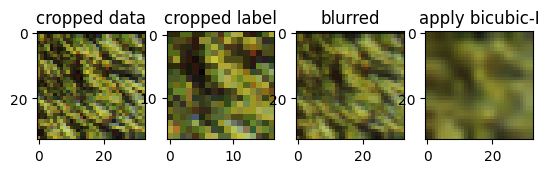

In [3]:
# params for dataset
data_path = "./T91/*.png"
test_path1 = "./Set5/Set5/*.png"
test_path2 = "./Set14/Set14/*.png"
sub_img_size, stride, upscale_factor = 33, 14, 3
# basic filter size of SRCNN
f1, f2, f3 = 9, 5, 5
out_img_size = sub_img_size - (f1+f2+f3) + 3
size_gap = (sub_img_size - out_img_size)//2

#params for dataloader
batch_size = 64
train_dataset = SRdataset(data_path, sub_img_size, size_gap, stride, upscale_factor)
# test_dataset1 = SRdataset(test_path1, sub_img_size, size_gap, stride, upscale_factor)
test_dataset2 = SRdataset(test_path2,sub_img_size, size_gap, stride, upscale_factor)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
test_loader2 = DataLoader(test_dataset2, batch_size = batch_size)

print(f"train_dataset 0's type:{type(train_dataset[0][0])}, shape:{train_dataset[0][0].shape}")

print(f"train_loader.dataset:{len(train_loader.dataset)}")
print(f"train_loader_length:{len(train_loader)}")
# train_loader test
for data, label in train_loader:
    img, lab = data[0], label[0]
    print(f"type of train data:{type(data)}, type of train label:{type(label)}, shape of d:{data.shape}, shape of lab:{label.shape}")
    break
    # plt.subplot(2,1,1) # subplots -> return fig, axes
    # plt.imshow(np.transpose(img,(1,2,0)))
    # plt.subplot(2,1,2)
    # plt.imshow(np.transpose(lab,(1,2,0)))
#    break

## Model

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device is {device}")

device is cuda


In [5]:
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,out_channels=64,kernel_size=9)
        self.conv2 = nn.Conv2d(64,32,kernel_size=5)
        self.conv3 = nn.Conv2d(32,3,kernel_size=5)
        self.relu = nn.ReLU()
        # 가중치 초기화
        nn.init.normal_(self.conv1.weight, mean=0, std=0.001)
        nn.init.normal_(self.conv2.weight, mean=0, std=0.001)
        nn.init.normal_(self.conv3.weight, mean=0, std=0.001)
        # nn.init.xavier_normal_(self.conv1.weight)
        # nn.init.xavier_normal_(self.conv2.weight)
        # nn.init.xavier_normal_(self.conv3.weight)
        # bias 초기화
        # nn.init.constant_(self.conv1.bias, 0)
        # nn.init.constant_(self.conv2.bias, 0)
        # nn.init.constant_(self.conv3.bias, 0)

        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        nn.init.zeros_(self.conv3.bias)
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)

        return x




## Train & Eval

**모델 파라미터와 bias 초기화, lr 변화, optimizer종류,psnr함수 적용**

In [6]:
import tqdm

# Super Resolution 평가 함수, mse가 작을 수록 좋은 지표 (psnr값이 클수록)
def psnr(pred, label):
    # 픽셀 최대값으로 정규화, 최대값의 제곱은 1.0
    #pTmp = pred / 255.0; #lTmp = label / 255.0
    # MSE(Mean Squared Error) 계산
    mse = torch.mean((pred - label) ** 2)  
    # log10(1**2/mse) -> log10(1/sqrt(mse))
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def train(train_loader,model,lossF, optimizer):
    # dataSize = len(train_loader.dataset)
    for (data, label) in tqdm.tqdm(train_loader):
        data,label = data.to(device),label.to(device)
        optimizer.zero_grad()
        pred = model(data)
        loss = lossF(pred,label)
        # batchPsnr = psnr(pred,label) / len(data)

        
        loss.backward()
        optimizer.step()

        # if batchNumber % 100 == 0:
        #     loss , currentDataNum, psnrValue = loss.item(), (batchNumber+1) * len(data), batchPsnr
        #     print(f"loss:{loss}, psnr value:{psnrValue}, at the {currentDataNum}/{dataSize}")
    

def test(test_loader, model, lossF):
    batchTotalSize = len(test_loader)
    totalLoss = 0
    finalPsnr = 0.0
    with torch.no_grad():
        for data, label in tqdm.tqdm(test_loader):
            data , label = data.to(device), label.to(device)
            pred = model(data)
            totalLoss += lossF(pred,label).item()
            finalPsnr += psnr(pred,label) / len(data)
    print(f"\ntest loss:{totalLoss / batchTotalSize}, test psnr: {finalPsnr / batchTotalSize}")

In [7]:
epoch = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = SRCNN().to(device)
# # 레이어별 다른 lr설정을 위한 네트워크 파라이터 cutomize
c_parameters, c_lr = [] , {'conv3.weight':1e-5}

for name, param in model.named_parameters():
    if name in c_lr: c_parameters.append({'params':param, 'lr':c_lr[name]})
    else: c_parameters.append({'params':param})

lossF = nn.MSELoss()
# basic lr -> 0.0001
optimizer = optim.Adam(c_parameters , lr = 1e-4)
# optimizer = optim.Adam(model.parameters(), lr = 1e-4)  

print(model)
for epochNum in range(epoch):
    if (epochNum+1)%10 == 0:print(f"Train epoch:{epochNum+1}-------------")
    train(train_loader,model,lossF,optimizer)

print("Train end")



cuda
SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
)


100%|██████████| 346/346 [00:02<00:00, 169.49it/s]


Train epoch:10-------------


100%|██████████| 346/346 [00:02<00:00, 166.28it/s]


Train epoch:20-------------


100%|██████████| 346/346 [00:02<00:00, 168.27it/s]


Train epoch:30-------------


100%|██████████| 346/346 [00:02<00:00, 169.53it/s]


Train epoch:40-------------


100%|██████████| 346/346 [00:02<00:00, 169.45it/s]


Train epoch:50-------------


100%|██████████| 346/346 [00:02<00:00, 169.61it/s]


Train epoch:60-------------


100%|██████████| 346/346 [00:02<00:00, 169.67it/s]


Train epoch:70-------------


100%|██████████| 346/346 [00:02<00:00, 164.38it/s]


Train epoch:80-------------


100%|██████████| 346/346 [00:02<00:00, 163.42it/s]


Train epoch:90-------------


100%|██████████| 346/346 [00:02<00:00, 161.25it/s]


Train epoch:100-------------


100%|██████████| 346/346 [00:02<00:00, 159.95it/s]


Train epoch:110-------------


100%|██████████| 346/346 [00:02<00:00, 163.71it/s]


Train epoch:120-------------


100%|██████████| 346/346 [00:02<00:00, 164.52it/s]


Train epoch:130-------------


100%|██████████| 346/346 [00:02<00:00, 163.95it/s]


Train epoch:140-------------


100%|██████████| 346/346 [00:02<00:00, 164.65it/s]


Train epoch:150-------------


100%|██████████| 346/346 [00:02<00:00, 164.57it/s]


Train epoch:160-------------


100%|██████████| 346/346 [00:02<00:00, 164.08it/s]


Train epoch:170-------------


100%|██████████| 346/346 [00:02<00:00, 162.70it/s]


Train epoch:180-------------


100%|██████████| 346/346 [00:02<00:00, 162.15it/s]


Train epoch:190-------------


100%|██████████| 346/346 [00:02<00:00, 159.51it/s]


Train epoch:200-------------


100%|██████████| 346/346 [00:02<00:00, 159.21it/s]

Train end


100%|██████████| 233/233 [00:00<00:00, 312.99it/s]



test loss:0.0027419657790037862, test psnr: 0.4680944085121155
test end, visual test start
picture shape:(768, 512)
torch.Size([1, 3, 512, 768])
SR img shape:(752, 496)


Text(0.5, 1.0, 'Super Resolution')

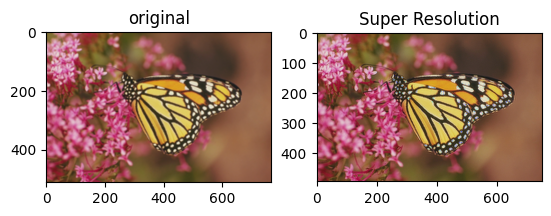

In [10]:
model.eval()
with torch.no_grad():
    test(test_loader2,model, lossF)

print("test end, visual test start")
transform = ToTensor(); imgName = 'monarch.png'
vtImage = Image.open('./Set14/Set14/'+imgName)
w,t = vtImage.size
temp = vtImage.resize((w//3,t//3),Image.BICUBIC)
vtImage = temp.resize((w,t),Image.BICUBIC)
print(f"picture shape:{vtImage.size}")
vtTensor = transform(vtImage).unsqueeze(0)
# vtTensor = vtTensor.to(torch.float32)
# vtTensor /= 255.0
print(vtTensor.shape)

model.eval()
with torch.no_grad():
    vtTensor = vtTensor.to(device)
    output = model(vtTensor)
vtOutput = ToPILImage()(output.squeeze(0))  # clamp는 min,max 사이의 값으로 tensor값을 제한해준다.
print(f"SR img shape:{vtOutput.size}")
vtFile = 'monarch3.png'
vtOutput.save('./testMonarch/'+ vtFile)



plt.subplot(1,2,1)
plt.imshow(vtImage)
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(vtOutput)
plt.title("Super Resolution")


## Model & parameters save and Load

In [11]:
torch.save(model.state_dict(),"SRCNN_200.pth")
print(f"model saved succedssfully")

model saved succedssfully


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SRCNN().to(device)
model.load_state_dict(torch.load("SRCNN_200.pth"))
print(f"model successfully loaded")

model successfully loaded


## Inference by real world data

In [14]:
# 다음 코드로 이미지 확장자를 확인할 수 있다. img.format
# with Image.open(image_path) as img:
#             # Check the format of the image
#             print(f"The format of the image is: {img.format}")
dataPath = './inferenceData/infer1.JPG'
jpgimg = Image.open(dataPath)
pngPath = dataPath.replace('.JPG','.PNG')
jpgimg.save(pngPath)
jpgimg.close()



picture shape:(640, 480)
result size:(624, 464)


Text(0.5, 1.0, 'Super Resolution')

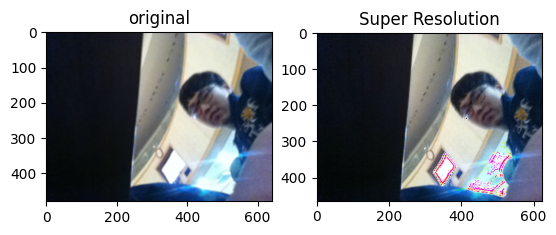

In [21]:
dataPath = pngPath
imgOri = Image.open(dataPath)
imgOri = imgOri.convert('RGB')
w,t = imgOri.size
temp2 = imgOri.resize((w//3,t//3),Image.BICUBIC)
imgOri = temp2.resize((w,t),Image.BICUBIC)
print(f"picture shape:{imgOri.size}")
transform = ToTensor()
img = transform(imgOri).unsqueeze(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img = img.to(device)
model.eval()
with torch.no_grad():
    output = model(img)
infed = ToPILImage()(output.squeeze(0))
print(f"result size:{infed.size}")

infed.save('./inferenceData/inferenced/inferenced1.png')
plt.subplot(1,2,1)
plt.imshow(imgOri)
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(infed)
plt.title('Super Resolution')